# Compact Convolutional Transformers (10 points)

In this task you will train Vision Transformer-like network for cifar10 images classification.

This task is based on paper [Escaping the Big Data Paradigm with Compact Transformers](https://arxiv.org/pdf/2104.05704.pdf)

By implementing all the missing code snippets you can get 10 points. Good luck!


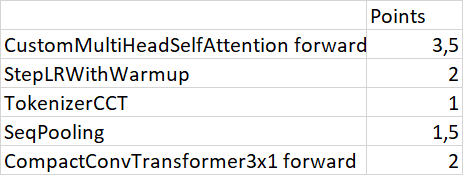

## CIFAR dataset

You have already met this dataset in seminars.

* 60k images of shape 3x32x32
* 10 different classes: planes, dogs, cats, trucks, etc.

In [1]:
# when running in colab, un-comment this
!wget https://cloud.imm.uran.ru/s/XCdWoSSK3wyeHYE/download/cifar.py

--2022-04-20 16:38:16--  https://cloud.imm.uran.ru/s/XCdWoSSK3wyeHYE/download/cifar.py
Resolving cloud.imm.uran.ru (cloud.imm.uran.ru)... 195.19.132.75
Connecting to cloud.imm.uran.ru (cloud.imm.uran.ru)|195.19.132.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2182 (2.1K) [text/x-python]
Saving to: ‘cifar.py’

cifar.py            100%[===================>]   2.13K  --.-KB/s    in 0s      

2022-04-20 16:38:17 (340 MB/s) - ‘cifar.py’ saved [2182/2182]



In [2]:
#!L
import numpy as np
import random
from cifar import load_cifar10
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("cifar_data")

class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck'])

print(X_train.shape,y_train.shape)

Load data from cifar_data/cifar-10-batches-py/test_batch
Dataset not found. Downloading...
(40000, 3, 32, 32) (40000,)


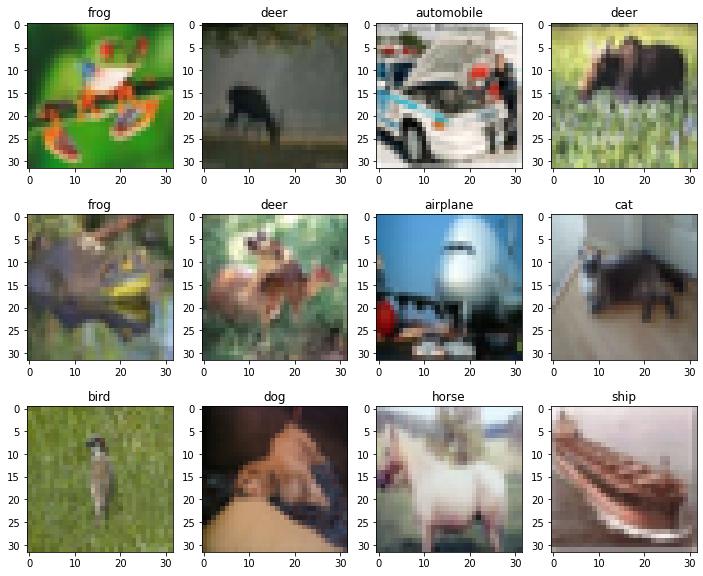

In [3]:
#!L
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(np.transpose(X_train[i],[1,2,0]))
    plt.title(class_names[y_train[i]])

## Prepare dataset and loss

The following code is based on homework 1-pt2 and should be familiar to you.

In [4]:
#!L
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import tqdm

In [5]:
#!L
def get_computing_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

device = get_computing_device()
print(f"Our main computing device is '{device}'")

Our main computing device is 'cuda:0'


In [6]:
#!L
def compute_loss(logits, y_batch):
    return F.cross_entropy(logits, y_batch).mean().cpu()

In [7]:
from torchvision import transforms
means = np.array((0.4914, 0.4822, 0.4465))
stds = np.array((0.2470, 0.2435, 0.2616))

transform_augment = transforms.Compose([
    transforms.RandomResizedCrop((32,32), scale=(0.9, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomRotation([-5, 5]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
    transforms.Normalize(means, stds),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

In [8]:
from torchvision.datasets import CIFAR10

#NUM_WORKERS = 16
NUM_WORKERS = 2

BATCH_SIZE = 50

train_loader = CIFAR10("./cifar_data/", train=True, transform=transform_augment)

train_batch_gen = torch.utils.data.DataLoader(train_loader, 
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=NUM_WORKERS)
val_loader = CIFAR10("./cifar_data/", train=False, transform=transform_test)

val_batch_gen = torch.utils.data.DataLoader(val_loader, 
                                              batch_size=BATCH_SIZE,
                                              shuffle=False,
                                              num_workers=NUM_WORKERS)


## Task 1. Multi-head attention

Your turn!

<img src="https://data-science-blog.com/wp-content/uploads/2022/01/mha_img_original.png" style="width:50%">

Let's implement MultiHeadAttention for beggining. It's already implemented in pytorch, so we will use `nn.MultiHeadAttention` for testing of your implementation.

As a reminder, (one-head) attention implements a simple formula: $\text{Attention}(Q,K,V) = \text{softmax}(\frac{QK^T}{\sqrt{d_k}})V$, where $d_k$ is size of K


**Tip: read about how the torch.matmul and torch.t methods work. Think about how they will work for batches and what dimension the tensors will have.**

In [ ]:
# Complete CustomMultiHeadSelfAttention in modules.py

Let's check that your implementation works like `torch.nn.MultiheadAttention`

In [10]:
# Determine the locations of auxiliary libraries and datasets.
# `AUX_DATA_ROOT` is where 'tiny-imagenet-2022.zip' is.

# Detect if we are in Google Colaboratory
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from pathlib import Path
if IN_COLAB:
    google.colab.drive.mount("/content/drive")
    
    # Change this if you created the shortcut in a different location
    AUX_DATA_ROOT = Path("/content/drive/MyDrive/DL HW2/part2")
    
    assert AUX_DATA_ROOT.is_dir(), "Have you forgot to 'Add a shortcut to Drive'?"
    
    import sys
    sys.path.append(str(AUX_DATA_ROOT))
else:
    AUX_DATA_ROOT = Path(".")

Mounted at /content/drive


In [11]:
%load_ext autoreload
%autoreload 2

In [12]:
from modules import * # CustomMultiHeadSelfAttention, StepLRWithWarmup,
                        #TokenizerCCT, SeqPooling, create_mlp, DropPath, TransformerEncoder, CompactConvTransformer3x1

In [13]:
mha = torch.nn.MultiheadAttention(embed_dim=128, num_heads=16, batch_first=True)

In [14]:
custom_mha = CustomMultiHeadSelfAttention(embed_dim=128, num_heads=16)
custom_mha.in_proj.weight = mha.in_proj_weight
custom_mha.in_proj.bias = mha.in_proj_bias
custom_mha.out_proj.weight = mha.out_proj.weight
custom_mha.out_proj.bias = mha.out_proj.bias

In [15]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

for _ in range(100):
    a = torch.rand((1, 10, 128))
    out1 = mha(a, a, a)[0].cpu().detach().numpy()
    out2 = custom_mha(a).cpu().detach().numpy()
    assert np.allclose(out1, out2, atol=1e-6), f"{out1} {out2}"
    
print ("Congratulations! It works!")

Congratulations! It works!


## Task 2: Step-wise learning rate with warm-up

Your task is to implement class that works as `torch.optim.lr_scheduler.StepLR` but supports warm-up.

First of all, examine the docstring and implementation of `StepLR` scheduler:

In [ ]:
torch.optim.lr_scheduler.StepLR??

Then implement `get_lr()` method. It should work as following:
1. If `self.last_epoch` is in `[0, self.warmup_epochs)`, then scheduler is in warm-up mode and learning rate should lineary increase during epochs from `self.warmup_lr_init` to `self.base_lrs` (which is the original learning rate of optimizer)
2. If `self.last_epoch` is equal to `self.warmup_epochs`, then just return `self.base_lrs`.
3. If `self.last_epoch - self.warmup_epochs` is not divisible by `self.step_size` then just return the previous learning rate which is available through `[group['lr'] for group in self.optimizer.param_groups]`
4. If `self.last_epoch - self.warmup_epochs` is divisible by `self.step_size` and the current learning rate multiplied by `self.gamma` is not less then self.min_lr, then multiply it and return the new value.
5. Otherwise just return the last learning rate

In [ ]:
# Complete class StepLRWithWarmup in modules.py

Let's check what you have written.


All asserts were passed!


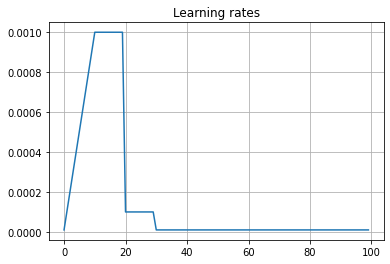

In [16]:
WARMUP_LR_INIT = 1e-5
WARMUP_EPOCHS = 10
STEP_SIZE = 10
GAMMA = 0.1
MIN_LR = 1e-5
OPT_LR = 1e-3

dummy_net = nn.Sequential(nn.Linear(10,10))
dummy_opt = torch.optim.Adam(dummy_net.parameters(), lr=OPT_LR)

scheduler = StepLRWithWarmup(dummy_opt, step_size=STEP_SIZE, gamma=GAMMA, 
                                      warmup_epochs=WARMUP_EPOCHS, warmup_lr_init=WARMUP_LR_INIT,
                                      min_lr=MIN_LR)

# we need to do at least one optimizer step before calling scheduler.step()
# in order to make pytorch happy
dummy_opt.step()  


learning_rates = []
for i in range(100):
    learning_rates.append(scheduler.get_last_lr())
    scheduler.step()
    
plt.plot(learning_rates)
plt.grid()
plt.title('Learning rates')
    
assert np.isclose(learning_rates[0], WARMUP_LR_INIT), \
    f"LR on the first epoch should be equal to {WARMUP_LR_INIT}, actual value {learning_rates[0]}"
assert np.isclose(learning_rates[WARMUP_EPOCHS], OPT_LR), \
    f"LR after warmup shold be equal to {OPT_LR}, actual value {learning_rates[WARMUP_EPOCHS]}"
assert np.isclose(learning_rates[WARMUP_EPOCHS+STEP_SIZE-1], OPT_LR), \
    f"LR after warmup + (STEP_SIZE-1) steps should be equal to {OPT_LR}, "\
    f"actual value {learning_rates[WARMUP_EPOCHS+STEP_SIZE-1]}"
assert np.isclose(learning_rates[WARMUP_EPOCHS+STEP_SIZE], OPT_LR*GAMMA), \
    f"LR after warmup + (STEP_SIZE) steps shold be equal to {OPT_LR*GAMMA}, " \
    f"actual value {learning_rates[WARMUP_EPOCHS+STEP_SIZE]}"

assert np.isclose(learning_rates[WARMUP_EPOCHS+STEP_SIZE*2-1], OPT_LR*GAMMA), \
    f"LR after warmup + (2*STEP_SIZE-1) steps should be equal to {OPT_LR*GAMMA}, "\
    f"actual value {learning_rates[WARMUP_EPOCHS+STEP_SIZE*2-1]}"
assert np.isclose(learning_rates[WARMUP_EPOCHS+2*STEP_SIZE], OPT_LR*GAMMA**2), \
    f"LR after warmup + (2*STEP_SIZE) steps shold be equal to {OPT_LR*GAMMA**2}, " \
    f"actual value {learning_rates[WARMUP_EPOCHS+2*STEP_SIZE]}"

assert np.isclose(learning_rates[WARMUP_EPOCHS+3*STEP_SIZE], OPT_LR*GAMMA**2), \
    f"LR after warmup + (3*STEP_SIZE) steps shold be equal to {OPT_LR*GAMMA**2}, " \
    f"actual value {learning_rates[WARMUP_EPOCHS+3*STEP_SIZE]}"

for i in range(WARMUP_EPOCHS):
    expected_val = WARMUP_LR_INIT + i*(OPT_LR-WARMUP_LR_INIT) / WARMUP_EPOCHS
    actual_val = learning_rates[i]
    assert np.isclose(actual_val, expected_val), \
        f"LR should linary increase from {WARMUP_LR_INIT} to {OPT_LR} during warmup."\
        f"Expected: {expected_val}, actual: {actual_val}, iteration={i}"
assert all(elem[0] >= MIN_LR for elem in learning_rates)
print("All asserts were passed!")

## Task 3. Compact Convolutional Transformer

During seminar you learned the main components of vision transformer: Tokenizer, Transformer encoder, position embeddings. At this point, it's expected that you have solved the ipython notebook from the seminar. If you didn't, then you know what to do before starting the current task)

Your task is to implement Compact Convolutional Transformer (CCT). It has two main changes comparing to the original ViT that was implemented during seminar. The first one is in tokenizer. Authors of CCT suggested to apply the first convolution with stride=1 allowing transformer to work with input patches that overlaps with each other. Since simple removing of stride increases the spatial resolution of the input tensor, we use MaxPool2d with desired stride in order to reduce the number of tokens.

In [ ]:
# Complete class TokenizerCCT in modules.py

The second change is that CCT uses learnable pooling instead of class token for global features extraction. Its formula is similar to attention formula:
$$y = \text{softmax}(WX^T+b) * X$$
where $X$ - layer input - matrix of shape [batch_size, n_tokens, n_embedding], $W$, $b$ - learnable parameters, that transform each token embedding vector to 1 element (in fact it's just a linear layer with output_dim=1).

In [ ]:
# Complete class SeqPooling in modules.py

### The following three modules were implemented by you during seminar, so you can just copy-paste their implementations.

MLP for transformer encoder is just a simple two-layer perceptron with GELU as non-linearity. It also uses Dropout after each Linear layer in order to reduce overfitting. Important thing is that size of hidden state on MLP is usually several times bigger than size of MLP input.

In [ ]:
# Complete create_mlp function in modules.py

Let's implement `DropPath` module. Its only parameter is `drop_prob` - probability to zero-out its input. Don't forget to devide the result on `(1-drop_prob)` in order to fix mean value of output in train mode (as you did in the first homework in dropout implementation).

In [ ]:
# Complete class DropPath in modules.py

In [ ]:
# Complete class TransformerEncoder in modules.py

The final class for the CCT. It looks the same as `VisionTransformer` class in seminar notebook, except the custom tokenizer and pooling. Here we implement a simple version of CCT, whose Tokenizer consist of one convolution of 3x3.

In [ ]:
# Complete class CompactConvTransformer3x1 in modules.py

## Final training 

If everything was implemented correctly, the following code will give you a model with > 84.5% accuracy (in fact it should be ~87.5%). If you see a smaller number, check your implementation of modules above.

In [17]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

model = CompactConvTransformer3x1(input_height=32, input_width=32, n_tokens=16, n_input_channels=3, 
                                  embedding_dim=128, num_layers=4, num_heads=4, num_classes=10, mlp_ratio=2)
model = model.to(device)
opt = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
scheduler = StepLRWithWarmup(opt, 40, gamma=0.3, warmup_epochs=10)

In [18]:
import time
from tqdm.notebook import tqdm_notebook
num_epochs = 120 # total amount of full passes over training data

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    train_loss = []
    val_accuracy = []
    
    for X_batch, y_batch in tqdm_notebook(train_batch_gen): # or train_batch_gen
        opt.zero_grad()
        # train on batch
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        logits = model(X_batch)
        loss = compute_loss(logits, y_batch)
        loss.backward()
        opt.step()
        train_loss.append(loss.data.numpy())
    print (scheduler.get_last_lr())
    scheduler.step()
        
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in tqdm_notebook(val_batch_gen): # or val_batch_gen
        X_batch = X_batch.to(device)
        y_batch = y_batch.numpy()
        logits = model(X_batch).cpu()
        y_pred = logits.max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss)))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy) * 100))

  0%|          | 0/1000 [00:00<?, ?it/s]

[1e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1 of 120 took 74.490s
  training loss (in-iteration): 	2.062383
  validation accuracy: 			32.21 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.00010899999999999999]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 2 of 120 took 74.244s
  training loss (in-iteration): 	1.715742
  validation accuracy: 			46.61 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.000208]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 3 of 120 took 74.364s
  training loss (in-iteration): 	1.485853
  validation accuracy: 			54.08 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.000307]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 4 of 120 took 73.547s
  training loss (in-iteration): 	1.334048
  validation accuracy: 			58.69 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.000406]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 5 of 120 took 73.702s
  training loss (in-iteration): 	1.227845
  validation accuracy: 			63.04 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.000505]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 6 of 120 took 73.611s
  training loss (in-iteration): 	1.149940
  validation accuracy: 			64.32 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.000604]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 7 of 120 took 73.186s
  training loss (in-iteration): 	1.084884
  validation accuracy: 			63.38 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0007030000000000001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 8 of 120 took 73.657s
  training loss (in-iteration): 	1.041669
  validation accuracy: 			68.39 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0008020000000000001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 9 of 120 took 73.607s
  training loss (in-iteration): 	1.011688
  validation accuracy: 			68.09 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0009010000000000001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 10 of 120 took 73.878s
  training loss (in-iteration): 	0.989332
  validation accuracy: 			67.74 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 11 of 120 took 73.728s
  training loss (in-iteration): 	0.965084
  validation accuracy: 			66.98 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 12 of 120 took 74.357s
  training loss (in-iteration): 	0.938724
  validation accuracy: 			70.39 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 13 of 120 took 74.463s
  training loss (in-iteration): 	0.898464
  validation accuracy: 			73.62 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 14 of 120 took 74.151s
  training loss (in-iteration): 	0.876878
  validation accuracy: 			70.41 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 15 of 120 took 74.299s
  training loss (in-iteration): 	0.850692
  validation accuracy: 			71.66 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 16 of 120 took 73.733s
  training loss (in-iteration): 	0.832075
  validation accuracy: 			73.93 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 17 of 120 took 74.389s
  training loss (in-iteration): 	0.805041
  validation accuracy: 			74.96 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 18 of 120 took 74.690s
  training loss (in-iteration): 	0.783682
  validation accuracy: 			76.09 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 19 of 120 took 74.103s
  training loss (in-iteration): 	0.774698
  validation accuracy: 			75.76 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 20 of 120 took 74.311s
  training loss (in-iteration): 	0.751434
  validation accuracy: 			77.28 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 21 of 120 took 74.649s
  training loss (in-iteration): 	0.736343
  validation accuracy: 			76.02 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 22 of 120 took 73.904s
  training loss (in-iteration): 	0.728082
  validation accuracy: 			75.75 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 23 of 120 took 73.856s
  training loss (in-iteration): 	0.714808
  validation accuracy: 			77.53 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 24 of 120 took 74.190s
  training loss (in-iteration): 	0.703992
  validation accuracy: 			76.27 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 25 of 120 took 74.636s
  training loss (in-iteration): 	0.693786
  validation accuracy: 			78.39 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 26 of 120 took 73.906s
  training loss (in-iteration): 	0.683840
  validation accuracy: 			78.62 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 27 of 120 took 74.023s
  training loss (in-iteration): 	0.677699
  validation accuracy: 			77.08 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 28 of 120 took 73.556s
  training loss (in-iteration): 	0.665963
  validation accuracy: 			77.96 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 29 of 120 took 73.645s
  training loss (in-iteration): 	0.653132
  validation accuracy: 			78.58 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 30 of 120 took 74.133s
  training loss (in-iteration): 	0.645782
  validation accuracy: 			78.95 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 31 of 120 took 74.370s
  training loss (in-iteration): 	0.635596
  validation accuracy: 			79.76 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 32 of 120 took 74.559s
  training loss (in-iteration): 	0.630465
  validation accuracy: 			78.49 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 33 of 120 took 74.529s
  training loss (in-iteration): 	0.621611
  validation accuracy: 			80.35 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 34 of 120 took 74.003s
  training loss (in-iteration): 	0.617909
  validation accuracy: 			81.10 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 35 of 120 took 74.377s
  training loss (in-iteration): 	0.608202
  validation accuracy: 			79.10 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 36 of 120 took 74.425s
  training loss (in-iteration): 	0.599647
  validation accuracy: 			79.26 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 37 of 120 took 74.869s
  training loss (in-iteration): 	0.594902
  validation accuracy: 			80.55 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 38 of 120 took 74.218s
  training loss (in-iteration): 	0.586901
  validation accuracy: 			81.08 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 39 of 120 took 74.868s
  training loss (in-iteration): 	0.586264
  validation accuracy: 			81.83 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 40 of 120 took 74.280s
  training loss (in-iteration): 	0.582945
  validation accuracy: 			81.16 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 41 of 120 took 75.086s
  training loss (in-iteration): 	0.573515
  validation accuracy: 			82.18 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 42 of 120 took 73.626s
  training loss (in-iteration): 	0.565423
  validation accuracy: 			81.56 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 43 of 120 took 73.818s
  training loss (in-iteration): 	0.563430
  validation accuracy: 			81.81 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 44 of 120 took 73.526s
  training loss (in-iteration): 	0.561748
  validation accuracy: 			81.37 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 45 of 120 took 73.443s
  training loss (in-iteration): 	0.557039
  validation accuracy: 			81.90 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 46 of 120 took 73.136s
  training loss (in-iteration): 	0.553036
  validation accuracy: 			83.39 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 47 of 120 took 73.141s
  training loss (in-iteration): 	0.548449
  validation accuracy: 			82.23 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 48 of 120 took 73.540s
  training loss (in-iteration): 	0.542379
  validation accuracy: 			82.27 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 49 of 120 took 73.229s
  training loss (in-iteration): 	0.543289
  validation accuracy: 			83.03 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.001]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 50 of 120 took 73.543s
  training loss (in-iteration): 	0.535094
  validation accuracy: 			82.19 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 51 of 120 took 73.824s
  training loss (in-iteration): 	0.426337
  validation accuracy: 			85.31 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 52 of 120 took 73.525s
  training loss (in-iteration): 	0.404079
  validation accuracy: 			85.46 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 53 of 120 took 73.537s
  training loss (in-iteration): 	0.393341
  validation accuracy: 			85.18 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 54 of 120 took 73.407s
  training loss (in-iteration): 	0.385767
  validation accuracy: 			85.94 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 55 of 120 took 73.652s
  training loss (in-iteration): 	0.374370
  validation accuracy: 			85.88 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 56 of 120 took 73.734s
  training loss (in-iteration): 	0.374290
  validation accuracy: 			85.87 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 57 of 120 took 73.639s
  training loss (in-iteration): 	0.365571
  validation accuracy: 			85.70 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 58 of 120 took 73.610s
  training loss (in-iteration): 	0.365063
  validation accuracy: 			85.55 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 59 of 120 took 73.898s
  training loss (in-iteration): 	0.360675
  validation accuracy: 			85.40 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 60 of 120 took 73.814s
  training loss (in-iteration): 	0.355865
  validation accuracy: 			85.53 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 61 of 120 took 74.109s
  training loss (in-iteration): 	0.352838
  validation accuracy: 			85.85 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 62 of 120 took 73.897s
  training loss (in-iteration): 	0.350892
  validation accuracy: 			86.33 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 63 of 120 took 73.904s
  training loss (in-iteration): 	0.349309
  validation accuracy: 			85.61 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 64 of 120 took 74.348s
  training loss (in-iteration): 	0.344359
  validation accuracy: 			85.57 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 65 of 120 took 74.246s
  training loss (in-iteration): 	0.340206
  validation accuracy: 			85.88 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 66 of 120 took 75.149s
  training loss (in-iteration): 	0.339872
  validation accuracy: 			86.25 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 67 of 120 took 75.250s
  training loss (in-iteration): 	0.335731
  validation accuracy: 			85.66 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 68 of 120 took 74.307s
  training loss (in-iteration): 	0.334239
  validation accuracy: 			86.13 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 69 of 120 took 74.588s
  training loss (in-iteration): 	0.332453
  validation accuracy: 			86.68 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 70 of 120 took 77.613s
  training loss (in-iteration): 	0.326764
  validation accuracy: 			86.52 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 71 of 120 took 76.159s
  training loss (in-iteration): 	0.330416
  validation accuracy: 			86.00 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 72 of 120 took 74.209s
  training loss (in-iteration): 	0.323624
  validation accuracy: 			86.25 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 73 of 120 took 75.425s
  training loss (in-iteration): 	0.320172
  validation accuracy: 			85.95 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 74 of 120 took 74.218s
  training loss (in-iteration): 	0.318340
  validation accuracy: 			85.93 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 75 of 120 took 74.658s
  training loss (in-iteration): 	0.320200
  validation accuracy: 			85.60 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 76 of 120 took 74.900s
  training loss (in-iteration): 	0.321522
  validation accuracy: 			85.59 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 77 of 120 took 75.235s
  training loss (in-iteration): 	0.314911
  validation accuracy: 			86.08 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 78 of 120 took 75.563s
  training loss (in-iteration): 	0.309820
  validation accuracy: 			86.17 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 79 of 120 took 75.421s
  training loss (in-iteration): 	0.315648
  validation accuracy: 			86.02 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 80 of 120 took 75.299s
  training loss (in-iteration): 	0.307757
  validation accuracy: 			86.20 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 81 of 120 took 75.480s
  training loss (in-iteration): 	0.307615
  validation accuracy: 			86.25 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 82 of 120 took 75.408s
  training loss (in-iteration): 	0.306278
  validation accuracy: 			85.82 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 83 of 120 took 75.941s
  training loss (in-iteration): 	0.305905
  validation accuracy: 			86.68 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 84 of 120 took 75.374s
  training loss (in-iteration): 	0.299998
  validation accuracy: 			85.84 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 85 of 120 took 74.152s
  training loss (in-iteration): 	0.306357
  validation accuracy: 			86.13 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 86 of 120 took 74.684s
  training loss (in-iteration): 	0.300877
  validation accuracy: 			86.20 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 87 of 120 took 75.052s
  training loss (in-iteration): 	0.297659
  validation accuracy: 			86.17 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 88 of 120 took 74.379s
  training loss (in-iteration): 	0.291910
  validation accuracy: 			86.27 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 89 of 120 took 75.052s
  training loss (in-iteration): 	0.294138
  validation accuracy: 			86.14 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[0.0003]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 90 of 120 took 75.264s
  training loss (in-iteration): 	0.286646
  validation accuracy: 			85.60 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 91 of 120 took 74.525s
  training loss (in-iteration): 	0.243158
  validation accuracy: 			86.60 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 92 of 120 took 74.811s
  training loss (in-iteration): 	0.234699
  validation accuracy: 			86.79 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 93 of 120 took 74.809s
  training loss (in-iteration): 	0.232002
  validation accuracy: 			87.02 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 94 of 120 took 75.080s
  training loss (in-iteration): 	0.229039
  validation accuracy: 			86.90 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 95 of 120 took 75.557s
  training loss (in-iteration): 	0.226256
  validation accuracy: 			87.07 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 96 of 120 took 75.413s
  training loss (in-iteration): 	0.223292
  validation accuracy: 			86.83 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 97 of 120 took 75.233s
  training loss (in-iteration): 	0.221741
  validation accuracy: 			87.17 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 98 of 120 took 74.774s
  training loss (in-iteration): 	0.218439
  validation accuracy: 			86.98 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 99 of 120 took 75.040s
  training loss (in-iteration): 	0.213114
  validation accuracy: 			87.07 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 100 of 120 took 75.023s
  training loss (in-iteration): 	0.216008
  validation accuracy: 			86.64 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 101 of 120 took 75.160s
  training loss (in-iteration): 	0.217180
  validation accuracy: 			87.19 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 102 of 120 took 75.219s
  training loss (in-iteration): 	0.216424
  validation accuracy: 			86.92 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 103 of 120 took 75.532s
  training loss (in-iteration): 	0.214118
  validation accuracy: 			87.23 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 104 of 120 took 75.475s
  training loss (in-iteration): 	0.211571
  validation accuracy: 			87.34 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 105 of 120 took 76.086s
  training loss (in-iteration): 	0.207207
  validation accuracy: 			87.19 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 106 of 120 took 74.924s
  training loss (in-iteration): 	0.211018
  validation accuracy: 			87.05 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 107 of 120 took 75.429s
  training loss (in-iteration): 	0.209060
  validation accuracy: 			86.87 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 108 of 120 took 75.043s
  training loss (in-iteration): 	0.210867
  validation accuracy: 			87.38 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 109 of 120 took 76.155s
  training loss (in-iteration): 	0.207388
  validation accuracy: 			87.00 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 110 of 120 took 75.992s
  training loss (in-iteration): 	0.202673
  validation accuracy: 			86.91 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 111 of 120 took 76.002s
  training loss (in-iteration): 	0.204412
  validation accuracy: 			86.86 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 112 of 120 took 76.619s
  training loss (in-iteration): 	0.202307
  validation accuracy: 			87.02 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 113 of 120 took 76.912s
  training loss (in-iteration): 	0.204531
  validation accuracy: 			87.08 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 114 of 120 took 76.865s
  training loss (in-iteration): 	0.203061
  validation accuracy: 			87.29 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 115 of 120 took 76.849s
  training loss (in-iteration): 	0.199648
  validation accuracy: 			87.13 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 116 of 120 took 77.011s
  training loss (in-iteration): 	0.200237
  validation accuracy: 			87.36 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 117 of 120 took 76.642s
  training loss (in-iteration): 	0.194824
  validation accuracy: 			86.80 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 118 of 120 took 76.822s
  training loss (in-iteration): 	0.193390
  validation accuracy: 			86.82 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 119 of 120 took 76.463s
  training loss (in-iteration): 	0.198260
  validation accuracy: 			86.86 %


  0%|          | 0/1000 [00:00<?, ?it/s]

[8.999999999999999e-05]


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 120 of 120 took 76.997s
  training loss (in-iteration): 	0.198714
  validation accuracy: 			87.05 %
